In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Liberation Serif'

import logging
import pickle
from datetime import datetime
import os
from data_processing import gen_ckpt_steps
from conv_plots_funcs import get_seg_starts_per_config
import torch
import gc
from core.config import Config
from get_last_checkpoint import split_path
from haystack_plots import load_quartiles_ckpt_files
from data_train import set_config_params, gen_ckpt_pred_steps

/home/sultand/quick_and_dirty_moss/src
Using device: cuda
/home/sultand/quick_and_dirty_moss/src
Using device: cuda
CUDA_VISIBLE_DEVICES: None


In [2]:
config = Config()
model_name = "ortho_haar_medium_single_gpu"

output_dir, ckpt_dir, experiment_name = set_config_params(config, model_name)

datasource = "val"


colors = ['#000000', '#005CAB', '#E31B23', '#FFC325', '#00A651', '#9B59B6']



ORTHO HAAR MEDIUM MODEL 1 GPU




In [ ]:
ckpt_steps = gen_ckpt_pred_steps(model_name)

datasources = ["val", "train"]
tf_avg_cong = []
tf_std_cong = []
zero_quartiles_cong = []
train_exs_cong = []
for datasource in datasources:
    train_exs = []
    tf_avg_lst = []
    tf_std_lst = []

    for ckpt in np.arange(1000, 182000, 1000):

        train_ex = ckpt*len(config.devices)*config.batch_size

        path = f"{output_dir}/prediction_errors{config.C_dist}_step={ckpt}.ckpt/train_conv_mult_cut_{datasource}_ortho_haar_state_dim_5_err_lss_examples.pkl"

        try:
            with open(path, "rb") as f:
                data = pickle.load(f)
                tf_errs = data["MOP"][0]
                zero_errs = data["Zero"][0]

                print(f"tf_errs.shape: {tf_errs.shape}")
                print(f"zero_errs.shape: {zero_errs.shape}")

                #set all np.inf to 0 in tf_errs and zero_errs
                tf_errs[np.isinf(tf_errs)] = 0
                zero_errs[np.isinf(zero_errs)] = 0


        except FileNotFoundError:
            print(f"ckpt {ckpt} not found")
            continue

        print(f"\n\n\nckpt: {ckpt}")
        tf_errs_mean_trial = np.mean(tf_errs, axis=1)
        print(f"tf_errs_mean_trial.shape: {tf_errs_mean_trial.shape}")

        tf_errs_mean = np.mean(tf_errs_mean_trial, axis=0)
        print(f"tf_errs_mean.shape: {tf_errs_mean.shape}")

        tf_avg = np.mean(tf_errs_mean, axis=0)
        tf_std = np.std(tf_errs_mean, axis=0) / np.sqrt(tf_errs_mean.shape[0])

        tf_avg_lst.append(tf_avg)
        tf_std_lst.append(tf_std)
        train_exs.append(train_ex)

    tf_avg_cong.append(tf_avg_lst)
    tf_std_cong.append(tf_std_lst)
    train_exs_cong.append(train_exs)


In [12]:
def gen_cong_lsts(config, model_name):

    output_dir, ckpt_dir, experiment_name = set_config_params(config, model_name)
    ckpt_steps = gen_ckpt_pred_steps(model_name)

    datasources = ["val", "train"]
    tf_avg_cong = []
    tf_std_cong = []
    train_exs_cong = []
    for datasource in datasources:
        train_exs = []
        tf_avg_lst = []
        tf_std_lst = []

        for ckpt in np.arange(1000, ckpt_steps[-1] + 1000, 1000):

            train_ex = ckpt*len(config.devices)*config.batch_size

            path = f"{output_dir}/prediction_errors{config.C_dist}_step={ckpt}.ckpt/train_conv_mult_cut_{datasource}_ortho_haar_state_dim_5_err_lss_examples.pkl"

            try:
                with open(path, "rb") as f:
                    data = pickle.load(f)
                    tf_errs = data["MOP"][0]

                    print(f"tf_errs.shape: {tf_errs.shape}")

                    #set all np.inf to 0 in tf_errs and zero_errs
                    tf_errs[np.isinf(tf_errs)] = 0


            except FileNotFoundError:
                print(f"ckpt {ckpt} not found at {path}")
                continue

            print(f"\n\n\nckpt: {ckpt}")
            tf_errs_mean_trial = np.mean(tf_errs, axis=1)
            print(f"tf_errs_mean_trial.shape: {tf_errs_mean_trial.shape}")

            tf_errs_mean = np.mean(tf_errs_mean_trial, axis=0)
            print(f"tf_errs_mean.shape: {tf_errs_mean.shape}")

            tf_avg = np.mean(tf_errs_mean, axis=0)
            tf_std = np.std(tf_errs_mean, axis=0) / np.sqrt(tf_errs_mean.shape[0])

            tf_avg_lst.append(tf_avg)
            tf_std_lst.append(tf_std)
            train_exs.append(train_ex)

        tf_avg_cong.append(tf_avg_lst)
        tf_std_cong.append(tf_std_lst)
        train_exs_cong.append(train_exs)

    return tf_avg_cong, tf_std_cong, train_exs_cong, output_dir
    

In [ ]:
fig,ax = plt.subplots(1, 1, figsize=(6, 3))
count = 0

print(f"len(tf_avg_cong): {len(tf_avg_cong)}")
for tf_avg_lst, tf_std_lst, train_exs in zip(tf_avg_cong, tf_std_cong, train_exs_cong):
    tf_avg_arr = np.array(tf_avg_lst)
    tf_std_arr = np.array(tf_std_lst)
    train_exs_arr = np.array(train_exs)
    print(f"tf_avg_lst: {tf_avg_lst}")
    ax.plot(train_exs_arr, tf_avg_arr, color=colors[count], linewidth=2, label=datasources[count], marker="o", markersize=3, zorder=1-count)
    ax.fill_between(train_exs_arr, tf_avg_arr - tf_std_arr, tf_avg_arr + tf_std_arr, color=colors[count], alpha=0.2, zorder=0)
    count += 1


ax.set_ylabel("Error")
ax.set_xlabel("# of Training Examples")
# ax.set_yscale("log")
ax.set_xscale("log")
ax.legend(loc="upper right", fontsize=8)
#set minor yticks every 0.01
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
#set gridlines
ax.grid(which='major', linestyle='--', linewidth=0.5)
ax.grid(which='minor', linestyle=':', linewidth=0.5)


fig.tight_layout()
time = datetime.now().strftime("%Y-%m-%d_%H")
fig_path = f"{output_dir}/figures/multi_cut/pretrain_loss/{model_name}_train_val_loss_cong_{time}.pdf"

os.makedirs(os.path.dirname(fig_path), exist_ok=True)
plt.savefig(fig_path, format='pdf')

In [ ]:
#import zipf distribution from scipy
from scipy.stats import zipfian

In [ ]:
#expectation of zipfian (k,n)
a = 1.5
n = 25

m = zipfian.mean(a, n)
print("Mean of Zipfian(1.5,25) = ", m)

avg_k = m

f6_err = (1 + 1 + 0.8 + 0.6 + 0.4 + 0.2)
print(f"f6_err: {f6_err}")

est_low_bound = avg_k*f6_err/(251)
print(f"est_low_bound: {est_low_bound}")

In [ ]:
fig,ax = plt.subplots(1, 1, figsize=(6, 3))
count = 0

print(f"len(tf_avg_cong): {len(tf_avg_cong)}")
for tf_avg_lst, tf_std_lst, train_exs in zip(tf_avg_cong, tf_std_cong, train_exs_cong):
    tf_avg_arr = np.array(tf_avg_lst) - est_low_bound
    tf_std_arr = np.array(tf_std_lst) - est_low_bound
    train_exs_arr = np.array(train_exs)
    print(f"tf_avg_lst: {tf_avg_lst}")
    ax.plot(train_exs_arr, tf_avg_arr, color=colors[count], linewidth=2, label=datasources[count], marker="o", markersize=3, zorder=1-count)
    ax.fill_between(train_exs_arr, tf_avg_arr - tf_std_arr, tf_avg_arr + tf_std_arr, color=colors[count], alpha=0.2, zorder=0)
    count += 1


ax.set_ylabel("Error")
ax.set_xlabel("# of Training Examples")
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend(loc="upper right", fontsize=8)
#set minor yticks every 0.01
# ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
#set gridlines
ax.grid(which='major', linestyle='--', linewidth=0.5)
ax.grid(which='minor', linestyle=':', linewidth=0.5)


fig.tight_layout()
time = datetime.now().strftime("%Y-%m-%d_%H")
fig_path = f"{output_dir}/figures/multi_cut/pretrain_loss/{model_name}_train_val_loss_cong_log_{time}.pdf"

os.makedirs(os.path.dirname(fig_path), exist_ok=True)
plt.savefig(fig_path, format='pdf')

## Pseudoinv baseline for init segs

In [ ]:
#load data from /data/shared/ICL_Kalman_Experiments/train_and_test_data/ortho_haar/val_interleaved_traces_ortho_haar_ident_C_multi_cut.pkl

with open("/data/shared/ICL_Kalman_Experiments/train_and_test_data/ortho_haar/val_interleaved_traces_ortho_haar_ident_C_multi_cut.pkl", "rb") as f:
    data = pickle.load(f)
    print(f"data.keys(): {data.keys()}")
    multi_sys_ys = data["multi_sys_ys"][0]
    multi_sys_ys = np.take(multi_sys_ys, np.arange(multi_sys_ys.shape[-1] - config.ny, multi_sys_ys.shape[-1]), axis=-1) #get the true test observations
    
    sys_choices_per_config = data["sys_choices_per_config"][0]
    seg_starts_per_config = data["seg_starts_per_config"][0]
    sys_inds_per_config = data["sys_inds_per_config"][0]
    real_seg_lens_per_config = data["real_seg_lens_per_config"][0]
    sys_dict_per_config = data["sys_dict_per_config"][0]

    print(f"multi_sys_ys.shape: {multi_sys_ys.shape}")
    print(f"len(sys_choices_per_config): {len(sys_choices_per_config)}")
    print(f"len(seg_starts_per_config): {len(seg_starts_per_config)}")
    print(f"len(sys_inds_per_config): {len(sys_inds_per_config)}")
    print(f"len(real_seg_lens_per_config): {len(real_seg_lens_per_config)}")

In [4]:
def get_multi_sys_ys(datasource):
    with open(f"/data/shared/ICL_Kalman_Experiments/train_and_test_data/ortho_haar/{datasource}_interleaved_traces_ortho_haar_ident_C_multi_cut.pkl", "rb") as f:
        data = pickle.load(f)
        print(f"data.keys(): {data.keys()}")
        multi_sys_ys = data["multi_sys_ys"][0]
        multi_sys_ys = np.take(multi_sys_ys, np.arange(multi_sys_ys.shape[-1] - config.ny, multi_sys_ys.shape[-1]), axis=-1) #get the true test observations
        
        sys_choices_per_config = data["sys_choices_per_config"][0]
        seg_starts_per_config = data["seg_starts_per_config"][0]
        sys_inds_per_config = data["sys_inds_per_config"][0]
        real_seg_lens_per_config = data["real_seg_lens_per_config"][0]
        sys_dict_per_config = data["sys_dict_per_config"][0]

        print(f"multi_sys_ys.shape: {multi_sys_ys.shape}")
        print(f"len(sys_choices_per_config): {len(sys_choices_per_config)}")
        print(f"len(seg_starts_per_config): {len(seg_starts_per_config)}")
        print(f"len(sys_inds_per_config): {len(sys_inds_per_config)}")
        print(f"len(real_seg_lens_per_config): {len(real_seg_lens_per_config)}")
    
    return multi_sys_ys, sys_choices_per_config, seg_starts_per_config, sys_inds_per_config, real_seg_lens_per_config, sys_dict_per_config

In [ ]:
multi_sys_ys, sys_choices_per_config, seg_starts_per_config, sys_inds_per_config, real_seg_lens_per_config, sys_dict_per_config = get_multi_sys_ys("val")

In [ ]:
print(f"sys_choices_per_config[0][0]: {sys_choices_per_config[0][0]}")
print(f"sys_inds_per_config[0][0]: {sys_inds_per_config[0][0]}")
print(f"sys_dict_per_config[0]: {sys_dict_per_config[0]}")

In [ ]:
from linalg_helpers import print_matrix

In [5]:
def pseudo_prediction(history):

    # print_matrix(history, "history")
    inds = history.shape[1]
    # print(f"inds: {inds}")

    leftmat = history[:, 1:inds]
    # print(f"leftmat.shape: {leftmat.shape}")
    # print_matrix(leftmat, "leftmat")
    rightmat = history[:, 0:inds-1]
    # print(f"rightmat.shape: {rightmat.shape}")
    # print_matrix(rightmat, "rightmat")

    Uhat = leftmat @ np.linalg.pinv(rightmat)
    # print(f"Uhat.shape: {Uhat.shape}")

    pred = Uhat @ history[:,-1]
    # print(f"pred.shape: {pred.shape}")
    return pred

In [6]:
def compute_pseudo_pred_errs(multi_sys_ys, seg_starts_per_config, real_seg_lens_per_config, sys_choices_per_config):
    pseudo_pred_errs = np.zeros_like(multi_sys_ys[:,:,:,0])
    print(f"pseudo_pred_errs.shape: {pseudo_pred_errs.shape}")

    for conf in range(multi_sys_ys.shape[0]):

        # print(f"sys_choices_per_config[conf]: {sys_choices_per_config[conf]}")

        errs_conf = np.zeros_like(multi_sys_ys[conf,:,:,0])
        # print(f"errs_conf.shape: {errs_conf.shape}")

        sys_init_ind_dict = {} # a dictionary that holds the system indices and how many initial indices have been seen for the config

        sys_appear = [] #holds the system indices that appear in the config

        seg_count = 0
        for seg in seg_starts_per_config[conf]:
            
            current_sys = sys_choices_per_config[conf][seg_count]
            # print(f"\n\ncurrent_sys: {current_sys}")
            if current_sys not in sys_appear: # if the system has not appeared before
                start_ind = seg + 1
                # print(f"start_ind: {start_ind}")
                real_seg_len = real_seg_lens_per_config[conf][seg_count]
                # print(f"real_seg_len: {real_seg_len}")
                end_ind = start_ind + real_seg_len
                # print(f"end_ind: {end_ind}")
                segment = multi_sys_ys[conf][:, start_ind:end_ind, :]
                # print(f"segment.shape: {segment.shape}")
                # print(f"segment: {segment}\n")
                sys_init_ind_dict[current_sys] = segment # add the system to the dictionary with the segment
                sys_appear.append(current_sys) #append the system to the list of systems that have appeared

                for ys_ind in range(start_ind+1, end_ind): #generate the pseudo prediction for each ys_ind in the segment and compute the squared error
                    hist = multi_sys_ys[conf][0, start_ind:ys_ind, :].T

                    pred = pseudo_prediction(hist)
                    # print(f"pred: {pred}")
                    # print(f'pred.shape: {pred.shape}')
                    # print(f"multi_sys_ys[conf][0, ys_ind, :]: {multi_sys_ys[conf][0, ys_ind, :]}")
                    true = multi_sys_ys[conf][0, ys_ind, :]
                    
                    errs_conf[0, ys_ind] = np.linalg.norm(pred - true)**2

                    # print(f"errs_conf[0, {ys_ind}, :]: {errs_conf[0, ys_ind, :]}")
                    # print(f"ys_ind: {ys_ind}")
                    # print(f"hist.shape: {hist.shape}")

            elif sys_init_ind_dict[current_sys].shape[1] < 6: # still need to see 6 examples of the system
                
                old_seg_len = sys_init_ind_dict[current_sys].shape[1]
                # print(f"old segment.shape: {sys_init_ind_dict[current_sys].shape}")
                start_ind = seg + 1
                # print(f"start_ind: {start_ind}")
                real_seg_len = real_seg_lens_per_config[conf][seg_count]
                # print(f"real_seg_len: {real_seg_len}")
                end_ind = start_ind + real_seg_len
                # print(f"end_ind: {end_ind}")
                segment = multi_sys_ys[conf][:, start_ind:end_ind, :]
                # print(f"new segment.shape: {segment.shape}")

                segment = np.concatenate((sys_init_ind_dict[current_sys], segment), axis=1) # concatenate the new segment with the old segment

                # print(f"segment.shape: {segment.shape}")
                # print(f"segment: {segment}\n")
                sys_init_ind_dict[current_sys] = segment # add the system to the dictionary with the segment
                sys_appear.append(current_sys) #append the system to the list of systems that have appeared

                hist_count = 1
                for ys_ind in range(start_ind+1, end_ind): #generate the pseudo prediction for each ys_ind in the segment and compute the squared error
                    hist = segment[0, 0:old_seg_len + hist_count, :].T

                    pred = pseudo_prediction(hist)
                    # print(f"pred: {pred}")
                    # print(f'pred.shape: {pred.shape}')
                    # print(f"multi_sys_ys[conf][0, ys_ind, :]: {multi_sys_ys[conf][0, ys_ind, :]}")
                    true = multi_sys_ys[conf][0, ys_ind, :]
                    
                    errs_conf[0, ys_ind] = np.linalg.norm(pred - true)**2

                    # print(f"errs_conf[0, {ys_ind}, :]: {errs_conf[0, ys_ind]}")
                    # print(f"ys_ind: {ys_ind}")
                    hist_count += 1

            else: # have already seen 6 examples of the system
                pass

            seg_count += 1
        
        pseudo_pred_errs[conf] = errs_conf

    return pseudo_pred_errs

In [ ]:
pseudo_pred_errs = np.zeros_like(multi_sys_ys[:,:,:,0])
print(f"pseudo_pred_errs.shape: {pseudo_pred_errs.shape}")

for conf in range(multi_sys_ys.shape[0]):

    # print(f"sys_choices_per_config[conf]: {sys_choices_per_config[conf]}")

    errs_conf = np.zeros_like(multi_sys_ys[conf,:,:,0])
    # print(f"errs_conf.shape: {errs_conf.shape}")

    sys_init_ind_dict = {} # a dictionary that holds the system indices and how many initial indices have been seen for the config

    sys_appear = [] #holds the system indices that appear in the config

    seg_count = 0
    for seg in seg_starts_per_config[conf]:
        
        current_sys = sys_choices_per_config[conf][seg_count]
        # print(f"\n\ncurrent_sys: {current_sys}")
        if current_sys not in sys_appear: # if the system has not appeared before
            start_ind = seg + 1
            # print(f"start_ind: {start_ind}")
            real_seg_len = real_seg_lens_per_config[conf][seg_count]
            # print(f"real_seg_len: {real_seg_len}")
            end_ind = start_ind + real_seg_len
            # print(f"end_ind: {end_ind}")
            segment = multi_sys_ys[conf][:, start_ind:end_ind, :]
            # print(f"segment.shape: {segment.shape}")
            # print(f"segment: {segment}\n")
            sys_init_ind_dict[current_sys] = segment # add the system to the dictionary with the segment
            sys_appear.append(current_sys) #append the system to the list of systems that have appeared

            for ys_ind in range(start_ind+1, end_ind): #generate the pseudo prediction for each ys_ind in the segment and compute the squared error
                hist = multi_sys_ys[conf][0, start_ind:ys_ind, :].T

                pred = pseudo_prediction(hist)
                # print(f"pred: {pred}")
                # print(f'pred.shape: {pred.shape}')
                # print(f"multi_sys_ys[conf][0, ys_ind, :]: {multi_sys_ys[conf][0, ys_ind, :]}")
                true = multi_sys_ys[conf][0, ys_ind, :]
                
                errs_conf[0, ys_ind] = np.linalg.norm(pred - true)**2

                # print(f"errs_conf[0, {ys_ind}, :]: {errs_conf[0, ys_ind, :]}")
                # print(f"ys_ind: {ys_ind}")
                # print(f"hist.shape: {hist.shape}")

        elif sys_init_ind_dict[current_sys].shape[1] < 6: # still need to see 6 examples of the system
            
            old_seg_len = sys_init_ind_dict[current_sys].shape[1]
            # print(f"old segment.shape: {sys_init_ind_dict[current_sys].shape}")
            start_ind = seg + 1
            # print(f"start_ind: {start_ind}")
            real_seg_len = real_seg_lens_per_config[conf][seg_count]
            # print(f"real_seg_len: {real_seg_len}")
            end_ind = start_ind + real_seg_len
            # print(f"end_ind: {end_ind}")
            segment = multi_sys_ys[conf][:, start_ind:end_ind, :]
            # print(f"new segment.shape: {segment.shape}")

            segment = np.concatenate((sys_init_ind_dict[current_sys], segment), axis=1) # concatenate the new segment with the old segment

            # print(f"segment.shape: {segment.shape}")
            # print(f"segment: {segment}\n")
            sys_init_ind_dict[current_sys] = segment # add the system to the dictionary with the segment
            sys_appear.append(current_sys) #append the system to the list of systems that have appeared

            hist_count = 1
            for ys_ind in range(start_ind+1, end_ind): #generate the pseudo prediction for each ys_ind in the segment and compute the squared error
                hist = segment[0, 0:old_seg_len + hist_count, :].T

                pred = pseudo_prediction(hist)
                # print(f"pred: {pred}")
                # print(f'pred.shape: {pred.shape}')
                # print(f"multi_sys_ys[conf][0, ys_ind, :]: {multi_sys_ys[conf][0, ys_ind, :]}")
                true = multi_sys_ys[conf][0, ys_ind, :]
                
                errs_conf[0, ys_ind] = np.linalg.norm(pred - true)**2

                # print(f"errs_conf[0, {ys_ind}, :]: {errs_conf[0, ys_ind]}")
                # print(f"ys_ind: {ys_ind}")
                hist_count += 1

        else: # have already seen 6 examples of the system
            pass

        seg_count += 1
    
    pseudo_pred_errs[conf] = errs_conf

In [ ]:
pseudo_pred_errs = compute_pseudo_pred_errs(multi_sys_ys, seg_starts_per_config, real_seg_lens_per_config, sys_choices_per_config)

In [7]:
def compute_avg_std(errs):
    print(f"errs.shape: {errs.shape}")

    errs_mean_trial = np.mean(errs, axis=1)
    print(f"errs_mean.shape: {errs_mean_trial.shape}")
    errs_mean = np.mean(errs_mean_trial, axis=0)
    print(f"errs_mean.shape: {errs_mean.shape}")
    avg = np.mean(errs_mean, axis=0)
    print(f"avg.shape: {avg.shape}")
    std = np.std(errs_mean, axis=0) / np.sqrt(errs_mean.shape[0])
    print(f"std.shape: {std.shape}")
    return avg, std

In [ ]:
pseudo_pred_avg, pseudo_pred_std = compute_avg_std(pseudo_pred_errs)

In [ ]:
print(f"pseudo_pred_errs.shape: {pseudo_pred_errs.shape}")

pseudo_pred_errs_mean_trial = np.mean(pseudo_pred_errs, axis=1)
print(f"pseudo_pred_errs_mean.shape: {pseudo_pred_errs_mean_trial.shape}")
pseudo_pred_errs_mean = np.mean(pseudo_pred_errs_mean_trial, axis=0)
print(f"pseudo_pred_errs_mean.shape: {pseudo_pred_errs_mean.shape}")
pseudo_pred_avg = np.mean(pseudo_pred_errs_mean, axis=0)
print(f"pseudo_pred_avg.shape: {pseudo_pred_avg.shape}")
pseudo_pred_std = np.std(pseudo_pred_errs_mean, axis=0) / np.sqrt(pseudo_pred_errs_mean.shape[0])
print(f"pseudo_pred_std.shape: {pseudo_pred_std.shape}")


In [8]:
def compute_pseudo_pred_avg_pipeline(datasource):
    multi_sys_ys, sys_choices_per_config, seg_starts_per_config, sys_inds_per_config, real_seg_lens_per_config, sys_dict_per_config = get_multi_sys_ys(datasource)

    pseudo_pred_errs = compute_pseudo_pred_errs(multi_sys_ys, seg_starts_per_config, real_seg_lens_per_config, sys_choices_per_config)
    pseudo_pred_avg, pseudo_pred_std = compute_avg_std(pseudo_pred_errs)
    return pseudo_pred_avg, pseudo_pred_std

## compute the pseudo_predictor error for train and val

In [ ]:
pseudo_pred_stats = {}
for datasource in ["train", "val"]:
    if datasource == "val":
        label = "Test"
    else:
        label = "Train"
    pseudo_pred_avg, pseudo_pred_std = compute_pseudo_pred_avg_pipeline(datasource)
    
    pseudo_pred_stats[label] = (pseudo_pred_avg, pseudo_pred_std)

## pretraining x-axis function

In [ ]:
def format_scientific(x):
    # Format to scientific notation
    s = f"{x:.0e}"
    # Remove leading zeros in the exponent part
    return s.replace('e-0', 'e-').replace('e+0', 'e+')

def plot_haystack_train_conv_pretrain_x_axis(config, colors, fin_quartiles_ckpt, beg_quartiles_ckpt, x_values_orig, train_exs_cong, tf_avg_cong, matching_indices, haystack_len, experiment, steps, nope, abs_err=False, finals=True, fig=None, ax=None, model_count=None, size=None, restart=False):

    markers = ['.','x', '>']
    

    #set x_values to be train_exs_cong[0] at the matching indices
    x_values = []
    for i in range(len(matching_indices)):
        x_values.append(tf_avg_cong[0][matching_indices[i]])

    #is x_values_orig the same length as x_values?
    if len(x_values_orig) != len(x_values):
        print(f"len x_values_orig: {len(x_values_orig)}")
        print(f"len x_values: {len(x_values)}")
        raise ValueError("x_values_orig and x_values are not the same length")

    valA = config.val_dataset_typ
    print(f"\n\nlen(x_values): {len(x_values)}")

    if fig is None and ax is None:
        fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 4))
        fig_len, ax_len = plt.subplots(1, 1, sharex=True, figsize=(6, 4))
        multi_model = False
    else:
        multi_model = True
        if not restart:
            steps = [1,2]

    early_stop_ind = None

    # if valA == "ortho":
    #     steps = [1,2,3,5,10]
    # else:
    #     steps = [1,2,3]

    if len(steps) > len(colors):
        # generate more colors from viridis colormap
        colors = plt.cm.viridis(np.linspace(0.1, 0.95, len(steps)))

    print(f"\n\n in haystack train conv plot valA: {valA}, abs_err: {abs_err}\n\n")

    for key in fin_quartiles_ckpt.keys():

        beg_lab_suffix = f" into seg. 1" if config.irrelevant_tokens and config.new_hay_insert else " after initial"

        final_lab_suffix = f" into seg. {config.num_sys_haystack + 1}" if config.irrelevant_tokens and config.new_hay_insert else " after final"

        if key == "MOP": #key == "OLS_analytical_ir_1" or key == "OLS_ir_1": #key == "MOP" or 
            col_count = 0
            for step in steps:

                if fig is None and ax is None:
                    col_ind = col_count
                else:
                    col_ind = model_count

                key_lab = "TF" if key == "MOP" else key
                qs = np.array(fin_quartiles_ckpt[key][step])
                qs = np.transpose(qs)

                if valA == "gaussA":
                    if not abs_err:
                        qs -= 1

                # #if key contains OLS then repeat the values in qs to be the length of x_values
                # if "OLS" in key:
                #     print(f"key: {key} qs shape: {qs.shape}")
                #     qs = np.repeat(qs, len(x_values), axis=0)
                #     print(f"qs shape after repeat: {qs.shape}")

                if step == 2:
                    #find the index of the minimum of qs[1]
                    early_stop_ind = np.argmin(qs[1])
                    print(f"early_stop_ind: {early_stop_ind}, x_values[early_stop_ind]: {x_values[early_stop_ind]}")

                    # raise NotImplementedError("Check the early stop index")
                
                if finals:

                    if multi_model and not restart:
                        label = f"{size}: {step} after final"
                    elif multi_model and restart:
                        label = f"{size}: {step} steps into seg. {haystack_len + 1}"
                    else:
                        label = f"{key_lab}: {step}{final_lab_suffix}"

                    ax.scatter(x_values, qs[1], label=label, s=25,marker=markers[min(2,step - 1)] if size is not None else ".", zorder=5 if key == "MOP" else 0, color=colors[model_count])
                    # if not valA == "gaussA":
                    #     ax.fill_between(x_values, qs[0], qs[2], alpha=0.2, color=colors[col_count])

                    # ax.fill_between(x_values, qs[0], qs[2], alpha=0.2, color=colors[col_count])

                    # ax_len.scatter(x_values, qs[1], label=f"{key_lab}: {step}{final_lab_suffix}", s=25, marker=".", zorder=5 if key == "MOP" else 0, color=colors[col_count])
                    # ax_len.fill_between(x_values, qs[0], qs[2], alpha=0.2, color=colors[col_count])

                    # color = ax.get_lines()[-1].get_color()

                else:
                    # color = colors[col_count]

                    beg_qs = np.array(beg_quartiles_ckpt[key][step])
                    beg_qs = np.transpose(beg_qs)
                    ax.scatter(x_values, qs[1], label=f"{size}: {step} after final" if size is not None else f"{key_lab}: {step}{final_lab_suffix}", s=25, marker=markers[min(2,step - 1)] if size is not None else ".", zorder=5 if key == "MOP" else 0, color=colors[model_count])
                # #set the color to the same as the fin quartiles
                # ax.plot(x_values, beg_qs[1], label=f"{key_lab}: {step}{beg_lab_suffix}", markersize=1 if "OLS" in key_lab else 5, marker="x", color=color, linestyle="-" if "OLS_ir" in key_lab else (":" if "OLS_analytical" in key_lab else "--"), linewidth=5 if "OLS_analytical" in key_lab else 2)

                # # if not valA == "gaussA":
                # #     ax.fill_between(x_values, beg_qs[0], beg_qs[2], alpha=0.2, color=color)
                # ax.fill_between(x_values, beg_qs[0], beg_qs[2], alpha=0.2, color=color)

                # ax_len.plot(x_values, beg_qs[1], label=f"{key_lab}: {step}{beg_lab_suffix}", markersize=1 if "OLS" in key_lab else 5, marker="x", color=color, linestyle="-" if "OLS_ir" in key_lab else (":" if "OLS_analytical" in key_lab else "--"), linewidth=5 if "OLS_analytical" in key_lab else 2)
                # ax_len.fill_between(x_values, beg_qs[0], beg_qs[2], alpha=0.2, color=color)

                col_count += 1

    # plt.tight_layout()
    # plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.15)  # Adjust margins as needed

    if config.n_embd == 128:
        #find the index in train_exs_cong[0] that is closest to 122000*config.batch_size
        closest_ind = np.argmin(np.abs(np.array(train_exs_cong[0]) - (122000*config.batch_size)))
        closest_tf_avg = tf_avg_cong[0][closest_ind]
        #make a vertical line of the closest_tf_avg
        ax.axvline(x=closest_tf_avg, color="red", linestyle="--", linewidth=1.5)

    if not multi_model:
        ax.invert_xaxis()
    ax.set_xlabel("Pretraining Error", fontsize=14)
    ax.set_ylabel(f"Error " + ("Ratio" if valA == "gaussA" and not abs_err else ""), fontsize=14)
    if finals:
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
    ax.set_xscale('log')
    ax.grid(True, which="both")
    # have x-axis tick labels that are 9e-1, 8e-1, 7e-1, 6e-1, 5e-1, 4e-1, 3e-1, 2e-1, 1e-1, 9e-2, 8e-2, 7e-2, 6e-2
    xticks = [9e-1, 8e-1, 7e-1, 6e-1, 5e-1, 4e-1, 3e-1, 2e-1, 1e-1, 9e-2, 8e-2, 7e-2, 6e-2]
    ax.set_xticks(xticks)
    ax.set_xticklabels([format_scientific(x) for x in xticks], fontsize=8)

    # #format the y-axis tick labels to be in scientific notation
    # yticks = ax.get_yticks()
    # ax.set_yticks(yticks)
    # ax.set_yticklabels([format_scientific(y) for y in yticks], fontsize=8)
    
    ax.legend(fontsize=10, ncol=2 if valA =="ident" else 1, loc="lower left")
    # ax.set_xlim(x_values[0] - 1e3, x_values[-1] + 1e3)
    # ax.set_ylim([1e-3, 2e0])
    # ax.set_title(("Ortho" if valA == "ortho" else ("Gaussian" if valA == "gaussA" else "Identity")) + f" Haystack Length: {haystack_len} vs Training Examples")

    # ax_len.invert_xaxis()
    # ax_len.set_xlabel("Pretraining Error", fontsize=14)
    # ax_len.set_ylabel(f"Error " + ("Ratio" if valA == "gaussA" and not abs_err else ""), fontsize=14)
    # ax_len.set_yscale('linear')
    # ax_len.set_xscale('log')
    # ax_len.grid(True, which="both")
    # ax_len.legend(fontsize=8, ncol=2 if valA =="ident" else 1, loc="lower left", columnspacing=0.4) #"center right" if valA == "ident" else 
    # ax_len.set_xlim(x_values[0] - 1e3, x_values[-1] + 1e3)
    # ax_len.set_ylim([-1e-3, 1.35e0])

    #add the date and time to the filename
    now = datetime.now()
    timestamp = now.strftime("%Y%m%d_%H%M%S")


    figure_dir = f"../outputs/GPT2" + ("_NoPE" if nope else "") + f"/{experiment}/figures/multi_cut/pretrain_x_axis/" + (f"{config.datasource}/" if config.datasource != "val" else "") + ("fix_needle_" if config.fix_needle else "") + ("opposite_ortho_" if config.opposite_ortho else "") + ("irrelevant_tokens/" if config.irrelevant_tokens else "") + ("same_tokens/" if config.same_tokens else "") + ("paren_swap/" if config.paren_swap else "") 
    os.makedirs(figure_dir, exist_ok=True)

    fig.tight_layout()
    # fig_len.tight_layout()
    
    if multi_model:
        if not (model_count == 3 and restart):
            return early_stop_ind
        
    print("saving figure")
    fig.savefig(figure_dir + ("backstory_" if config.backstory and config.mem_suppress else ("init_seg_" if config.init_seg and config.mem_suppress else "")) + ("masked_" if config.masking and config.mem_suppress else ("unmasked_" if not config.masking and config.mem_suppress else "")) + ("fix_needle_" if config.fix_needle else "") + ("opposite_ortho_" if config.opposite_ortho else "") + ("irrelevant_tokens_" if config.irrelevant_tokens else "") + ("same_tokens_" if config.same_tokens else "")+ ("paren_swap_" if config.paren_swap else "") + ("zero_cut_" if config.zero_cut else "") + ("new_hay_insert_" if config.new_hay_insert else "") + (f"late_start_{config.late_start}_" if config.late_start is not None else "") + ("abs_err_" if abs_err else "") + f"{valA}_embd_dim_{config.n_embd}_train_conv_pretrain_x_axis_all_models_haystack_len_{haystack_len}_{timestamp}_" + ("logscale" if finals else "linearscale") + ".pdf", transparent=True, format="pdf")
    
    # fig_len.savefig(figure_dir + ("backstory_" if config.backstory and config.mem_suppress else ("init_seg_" if config.init_seg and config.mem_suppress else "")) + ("masked_" if config.masking and config.mem_suppress else ("unmasked_" if not config.masking and config.mem_suppress else "")) + ("fix_needle_" if config.fix_needle else "") + ("opposite_ortho_" if config.opposite_ortho else "") + ("irrelevant_tokens_" if config.irrelevant_tokens else "") + ("same_tokens_" if config.same_tokens else "")+ ("paren_swap_" if config.paren_swap else "") + ("zero_cut_" if config.zero_cut else "") + ("new_hay_insert_" if config.new_hay_insert else "") + (f"late_start_{config.late_start}_" if config.late_start is not None else "") + ("abs_err_" if abs_err else "") + f"{valA}_embd_dim_{config.n_embd}_train_conv_pretrain_x_axis_haystack_len_{haystack_len}_{timestamp}_linearscale.pdf", transparent=True, format="pdf")

    plt.show()
    return early_stop_ind

In [ ]:
model_names = ["ortho_haar_tiny", "ortho_haar_small", "ortho_haar_medium_single_gpu", "ortho_haar_big"]

tf_avg_cong, tf_std_cong, train_exs_cong, output_dir = gen_cong_lsts(config, model_names[2])

In [ ]:
model_dir, experiment = split_path(output_dir)

haystack_len = 2

steps_in = [1, 2, 3, 7,8]

late_start = None
paren_swap = False
same_tokens = False
irrelevant_tokens = False
fix_needle = False
new_hay_insert = False
opposite_ortho = False
only_beg = False
fix_needle =False
datasource = "val"
acc = False


config.override("datasource", datasource) # set the datasource in the config object
config.override("acc", acc) # set the acc in the config object for using the ACCESS server

# config.override("late_start", late_start) # set the late_start in the config object
config.override("late_start", late_start)

config.override("paren_swap", paren_swap) # set the paren_swap in the config object
if config.paren_swap:
    print("Running paren swap experiment\n\n\n")

config.override("same_tokens", same_tokens) # set the same_tokens in the config object
if config.same_tokens:
    print("Running same tokens experiment\n\n\n")

config.override("irrelevant_tokens", irrelevant_tokens) # set the irrelevant_tokens in the config object
if config.irrelevant_tokens:
    print("Running irrelevant tokens experiment\n\n\n")

config.override("fix_needle", fix_needle) # set the fix_needle in the config object
if config.fix_needle:
    print("Running fix needle experiment\n\n\n")

config.override("new_hay_insert", new_hay_insert) # set the new_hay_insert in the config object
if config.new_hay_insert:
    print("Running new hay insertion experiment\n\n\n")

config.override("opposite_ortho", opposite_ortho) # set the opposite_ortho in the config object
if config.opposite_ortho:
    config.override("val_dataset_typ", "ortho")

config.override("only_beg", only_beg) # set the only_beg in the config object
if config.only_beg:
    print("only plotting the beginning evals\n\n\n")

train_conv_fin_quartiles_file, train_conv_beg_quartiles_file, x_values_file, fin_quartiles_ckpt, beg_quartiles_ckpt, x_values = load_quartiles_ckpt_files(config, haystack_len, model_dir, experiment, False)


In [ ]:
print(f"len(x_values): {len(x_values)}")
print(f"len(train_exs_cong[0]): {len(train_exs_cong[0])}")

print(f"x_values[0]: {x_values[0]}")
print(f"train_exs_cong[0][0]: {train_exs_cong[0][20]}")

train_exs_cong_arr = np.array(train_exs_cong[0])


# Safer approach to find matching indices between arrays
matching_indices = []
train_exs_values = []

# For each value in x_values, try to find a match in train_exs_cong
x_ind = 0
x_inds = []
for x in x_values:
    # Find where values match (within some small tolerance for floating point)
    matches = np.where(np.isclose(train_exs_cong_arr, x, rtol=1e-10))[0]
    
    if len(matches) > 0:
        # If found, use the first match
        matching_indices.append(matches[0])
        train_exs_values.append(train_exs_cong_arr[matches[0]])
        x_inds.append(x_ind)
    else:
        print(f"No match found for x_value: {x}")

    x_ind += 1

matching_indices = np.array(matching_indices)
train_exs_values = np.array(train_exs_values)

print(f"matching_indices: {matching_indices}")
print(f"x_inds: {x_inds}")
print(f"train_exs_values: {train_exs_values}")
print(f"x_values: {x_values}")

In [ ]:
plot_haystack_train_conv_pretrain_x_axis(config, colors, fin_quartiles_ckpt, beg_quartiles_ckpt, x_values, train_exs_cong, tf_avg_cong, matching_indices, haystack_len, experiment, steps_in, False, abs_err=False, fig=None, ax=None)

In [ ]:
model_dir, experiment = split_path(output_dir)



ORTHO HAAR TINY MODEL


len(full_range) 48
tf_errs.shape: (5000, 1, 251)



ckpt: 1000
tf_errs_mean_trial.shape: (5000, 251)
tf_errs_mean.shape: (251,)
tf_errs.shape: (5000, 1, 251)



ckpt: 2000
tf_errs_mean_trial.shape: (5000, 251)
tf_errs_mean.shape: (251,)
tf_errs.shape: (5000, 1, 251)



ckpt: 3000
tf_errs_mean_trial.shape: (5000, 251)
tf_errs_mean.shape: (251,)
tf_errs.shape: (5000, 1, 251)



ckpt: 4000
tf_errs_mean_trial.shape: (5000, 251)
tf_errs_mean.shape: (251,)
tf_errs.shape: (5000, 1, 251)



ckpt: 5000
tf_errs_mean_trial.shape: (5000, 251)
tf_errs_mean.shape: (251,)
tf_errs.shape: (5000, 1, 251)



ckpt: 6000
tf_errs_mean_trial.shape: (5000, 251)
tf_errs_mean.shape: (251,)
tf_errs.shape: (5000, 1, 251)



ckpt: 7000
tf_errs_mean_trial.shape: (5000, 251)
tf_errs_mean.shape: (251,)
tf_errs.shape: (5000, 1, 251)



ckpt: 8000
tf_errs_mean_trial.shape: (5000, 251)
tf_errs_mean.shape: (251,)
tf_errs.shape: (5000, 1, 251)



ckpt: 9000
tf_errs_mean_trial.shape: (5000, 251)
t

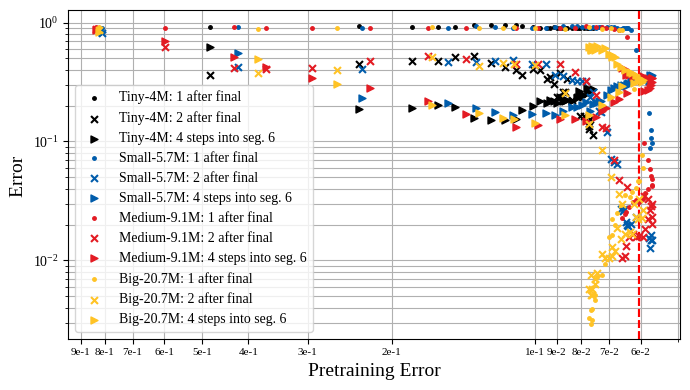

In [50]:
fig,ax = plt.subplots(1, 1, figsize=(7, 4))

ax.invert_xaxis()

colors = ['#000000', '#005CAB', '#E31B23', '#FFC325', '#00A651', '#9B59B6']


model_names = ["ortho_haar_tiny", "ortho_haar_small", "ortho_haar_medium_single_gpu", "ortho_haar_big"]


sizes = ["Tiny-4M", "Small-5.7M", "Medium-9.1M", "Big-20.7M"]
model_count = 0


haystack_len = 5

steps_in = [1, 2, 3, 7,8]

late_start = None
paren_swap = False
same_tokens = False
fix_needle = False
opposite_ortho = False
only_beg = False
fix_needle =False
datasource = "val"
acc = False

config = Config() # Assuming Config is a class that holds the configuration settings

# markers = ["o", "x"]
# linestyles = ["-", "--"]
for model_name in model_names:
    tf_avg_cong, tf_std_cong, train_exs_cong, output_dir = gen_cong_lsts(config, model_name) #get pretrain errors

    model_dir, experiment = split_path(output_dir)

    for i in np.arange(0,2):

        if i == 0:
            restart = False
            steps = steps_in
        else:
            restart = True
            steps = [4]
        irrelevant_tokens = restart
        new_hay_insert = restart
        config.override("datasource", datasource) # set the datasource in the config object
        config.override("acc", acc) # set the acc in the config object for using the ACCESS server

        # config.override("late_start", late_start) # set the late_start in the config object
        config.override("late_start", late_start)

        config.override("paren_swap", paren_swap) # set the paren_swap in the config object
        if config.paren_swap:
            print("Running paren swap experiment\n\n\n")

        config.override("same_tokens", same_tokens) # set the same_tokens in the config object
        if config.same_tokens:
            print("Running same tokens experiment\n\n\n")

        config.override("irrelevant_tokens", irrelevant_tokens) # set the irrelevant_tokens in the config object
        if config.irrelevant_tokens:
            print("Running irrelevant tokens experiment\n\n\n")

        config.override("fix_needle", fix_needle) # set the fix_needle in the config object
        if config.fix_needle:
            print("Running fix needle experiment\n\n\n")

        config.override("new_hay_insert", new_hay_insert) # set the new_hay_insert in the config object
        if config.new_hay_insert:
            print("Running new hay insertion experiment\n\n\n")

        config.override("opposite_ortho", opposite_ortho) # set the opposite_ortho in the config object
        if config.opposite_ortho:
            config.override("val_dataset_typ", "ortho")

        config.override("only_beg", only_beg) # set the only_beg in the config object
        if config.only_beg:
            print("only plotting the beginning evals\n\n\n")

        train_conv_fin_quartiles_file, train_conv_beg_quartiles_file, x_values_file, fin_quartiles_ckpt, beg_quartiles_ckpt, x_values = load_quartiles_ckpt_files(config, haystack_len, model_dir, experiment, False)

        print(f"train_conv_fin_quartiles_file: {train_conv_fin_quartiles_file}")

        train_exs_cong_arr = np.array(train_exs_cong[0])


        # Safer approach to find matching indices between arrays
        matching_indices = []
        train_exs_values = []

        # For each value in x_values, try to find a match in train_exs_cong
        x_ind = 0
        
        x_inds = []
        for x in x_values:
            # Find where values match (within some small tolerance for floating point)
            matches = np.where(np.isclose(train_exs_cong_arr, x, rtol=1e-10))[0]
            
            if len(matches) > 0:
                # If found, use the first match
                matching_indices.append(matches[0])
                train_exs_values.append(train_exs_cong_arr[matches[0]])
                x_inds.append(x_ind)
            else:
                print(f"No match found for x_value: {x}")

            x_ind += 1

        matching_indices = np.array(matching_indices)
        train_exs_values = np.array(train_exs_values)
        print(f"matching_indices: {matching_indices}")
        print(f"x_inds: {x_inds}")
        print(f"train_exs_values: {train_exs_values}")
        print(f"x_values: {x_values}")
        print(f"train_exs_cong_arr: {train_exs_cong_arr}")

        print(f"\n\nSTEPS: {steps}")

        plot_haystack_train_conv_pretrain_x_axis(config, colors, fin_quartiles_ckpt, beg_quartiles_ckpt, x_values, train_exs_cong, tf_avg_cong, matching_indices, haystack_len, experiment, steps=steps, nope=False, abs_err=False, finals=True, fig=fig, ax=ax, model_count=model_count, size=sizes[model_count], restart=restart)
    model_count += 1

In [ ]:
print(f"matching_indices: {matching_indices}")
print(f"train_exs_cong: {train_exs_cong[0]}")

## Pretraining loss plot

In [ ]:
fig,ax = plt.subplots(1, 1, figsize=(6, 4))


model_names = ["ortho_haar_tiny", "ortho_haar_small", "ortho_haar_medium_single_gpu", "ortho_haar_big"]

sizes = ["Tiny-4M", "Small-5.7M", "Medium-9.1M", "Big-20.7M"]
model_count = 0

markers = ["o", "x"]
linestyles = ["-", "--"]
for model_name in model_names:
    tf_avg_cong, tf_std_cong, train_exs_cong, output_dir = gen_cong_lsts(config, model_name)
    count = 0


    #capitalize the first letter of each datasource
    datasources = ["Test", "Train"]
    for tf_avg_lst, tf_std_lst, train_exs in zip(tf_avg_cong, tf_std_cong, train_exs_cong):
        print(f"count: {count}")
        tf_avg_arr = np.array(tf_avg_lst)
        tf_std_arr = np.array(tf_std_lst)
        train_exs_arr = np.array(train_exs)
        print(f"tf_avg_lst: {tf_avg_lst}")
        ax.plot(train_exs_arr, tf_avg_arr, color=colors[model_count], linewidth=2, label=f"{sizes[model_count]}: {datasources[count]}", marker=markers[count], linestyle=linestyles[count], markersize=5, zorder=2-count)
        ax.fill_between(train_exs_arr, tf_avg_arr - tf_std_arr, tf_avg_arr + tf_std_arr, color=colors[model_count], alpha=0.2, zorder=0)

        print(f"pseudo_pred_stats[datasources[count]][0]: {pseudo_pred_stats[datasources[count]][0]}")
        #plot the pseudo prediction error as a horizontal line
        count += 1

    if model_count == 2:
        train_exs_arr_for_pseudo = train_exs_arr

    model_count += 1


ax.plot(train_exs_arr_for_pseudo, pseudo_pred_stats["Test"][0]*np.ones_like(train_exs_arr_for_pseudo), color="black", linewidth=2, label=f"Pseudoinv Predictor", linestyle = ":", zorder=100)



ax.set_ylabel("Error")
ax.set_xlabel("# of Training Examples")
# ax.set_yscale("log")
ax.set_xscale("log")
ax.legend(loc="upper right", fontsize=8)
#set minor yticks every 0.01
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
#set gridlines
ax.grid(which='major', linestyle='--', linewidth=0.5)
ax.grid(which='minor', linestyle=':', linewidth=0.5)


fig.tight_layout()
time = datetime.now().strftime("%Y-%m-%d_%H")
fig_path = f"{output_dir}/figures/multi_cut/pretrain_loss/{model_name}_train_val_loss_cong_{time}.pdf"

os.makedirs(os.path.dirname(fig_path), exist_ok=True)
plt.savefig(fig_path, format='pdf')